# Animal Faces Transfer Learning

### This notebook contains the code to carry out the analysis of the transfer learning capacilities of the pre-trained model from task 1 and the ImageNet pre-trained model.
### First, the pre-trained model from task 1 will be loaded to get the CNN encoder to extract features to be passed along to a Logistic Regression model for classification. An analysis of the performance of the classifier will be made with respect to the features extracted.
### Then the same procedure will be done but for a ResNet model with ImageNet pre-trained weights.

In [1]:
import os
import numpy
import sklearn.metrics
import pandas
import matplotlib.pyplot as plt
import torch
from torch.utils import data
from torch.nn import Flatten
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

device = "cuda:0"

logistic_regression_classifier = LogisticRegression(random_state=42)

label_names = ["Cat", "Dog", "Wild"]

def load_data(_data_dir="Datasets/Corolectal Cancer/"):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),  
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet Normalization
    ])

    if not os.path.exists(_data_dir):
        raise FileNotFoundError(f"Dataset directory '{_data_dir}' does not exist.")

    full_dataset = ImageFolder(root=_data_dir, transform=transform)

    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = data.random_split(full_dataset, [train_size, test_size])

    return train_dataset, test_dataset


def create_dataloaders():
    train_dataset, test_dataset = load_data("Datasets/Animal Faces/")

    batch_size = 32

    train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader


def get_feature_and_label_maps(_model, _train_dataloader, _test_dataloader):
    for param in _model.parameters():
        param.requires_grad = False

    _model.to(device)

    full_train_feature_map_set = None

    full_train_label_set = None

    full_test_feature_map_set = None

    full_test_label_set = None

    flatten_layer = Flatten()

    for data, label in _train_dataloader:
        data, label = data.to(device), label.to(device)

        # Note: the desired output (i.e. output of last layer avgpool) is stored in a dictionary entry along with the rest, end dimensionality is 32x2048
        feature_map_dict = _model(data)
        flattened_feature_map = flatten_layer(feature_map_dict["avgpool"])

        if full_train_feature_map_set == None:
            full_train_feature_map_set = flattened_feature_map

            full_train_label_set = label
        else:
            full_train_feature_map_set = torch.vstack((full_train_feature_map_set, flattened_feature_map))
            
            full_train_label_set = torch.hstack((full_train_label_set, label))

    for data, label in _test_dataloader:
        data, label = data.to(device), label.to(device)

        # Note: the desired output (i.e. output of last layer avgpool) is stored in a dictionary entry along with the rest, end dimensionality is 32x2048
        feature_map_dict = _model(data)
        flattened_feature_map = flatten_layer(feature_map_dict["avgpool"])

        if full_test_feature_map_set == None:
            full_test_feature_map_set = flattened_feature_map

            full_test_label_set = label
        else:
            full_test_feature_map_set = torch.vstack((full_test_feature_map_set, flattened_feature_map))
            
            full_test_label_set = torch.hstack((full_test_label_set, label))

    return full_train_feature_map_set, full_test_feature_map_set, full_train_label_set, full_test_label_set


def create_embedding_dataframe(_full_train_feature_map_set, _full_train_label_set):
    reduction_fitter = TSNE(random_state=42)
    embeddings = reduction_fitter.fit_transform(_full_train_feature_map_set.cpu().numpy())
    embedding_dataframe = pandas.DataFrame(embeddings, columns=["x_embedded", "y_embedded"])
    embedding_dataframe["label"] = _full_train_label_set.cpu().numpy()

    return embedding_dataframe


def plot_tsne_embedding(_embedding_dataframe):
    colors = ["red", "green", "blue"]

    plt.style.use('seaborn-v0_8-dark')

    fig, ax = plt.subplots(figsize=(16,10))
    for i in _embedding_dataframe["label"].unique():
        label_embedding_values = _embedding_dataframe[_embedding_dataframe.label == i]
        ax.scatter(label_embedding_values.x_embedded, label_embedding_values.y_embedded, label=label_names[i], c=colors[i], alpha=0.5)

    ax.set_xlabel("Embedded Feature 1")
    ax.set_ylabel("Embedded Feature 2")

    ax.set_title("Feature Extractor Mappings Following TSNE Reduction")

    ax.legend()

    plt.show()


#### Colorectal Cancer Pre-trained Model

- Get the model from the `Models` directory

In [3]:
colorectal_cancer_model = resnet50(weights=None, num_classes=3)
colorectal_cancer_model.load_state_dict(torch.load("Models/ResNet_Rmsprop_Corolectal_Cancer_pre_trained.tar"))


C:\Users\trist\AppData\Local\Temp\ipykernel_17912\633430360.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  colorectal_cancer_model.load_state_dict(torch.load("Models/Re

<All keys matched successfully>

- Remnove the classification head

In [4]:
# uncomment to see list of layers except fc
# train_nodes, eval_nodes = get_graph_node_names(imagenet_model)
# print(train_nodes[:-1])

return_nodes = {
    'layer1': 'layer1',
    'layer2': 'layer2',
    'layer3': 'layer3',
    'layer4': 'layer4',
    'avgpool': 'avgpool'
}

# Note: this created model does not contain the flatten layer and so the output needs to have that applied first before going to the classifier
colorectal_cancer_model = create_feature_extractor(colorectal_cancer_model, return_nodes=return_nodes)


- Load the dataset and preprocess it

In [5]:
train_dataloader, test_dataloader = create_dataloaders()


- Get the Logistic Regression model

In [6]:
logistic_regression_classifier


LogisticRegression(random_state=42)

- Extract the features

In [8]:
full_train_feature_map_set, full_test_feature_map_set, full_train_label_set, full_test_label_set = get_feature_and_label_maps(colorectal_cancer_model, train_dataloader, test_dataloader)


In [9]:
embedding_dataframe = create_embedding_dataframe(full_train_feature_map_set, full_train_label_set)


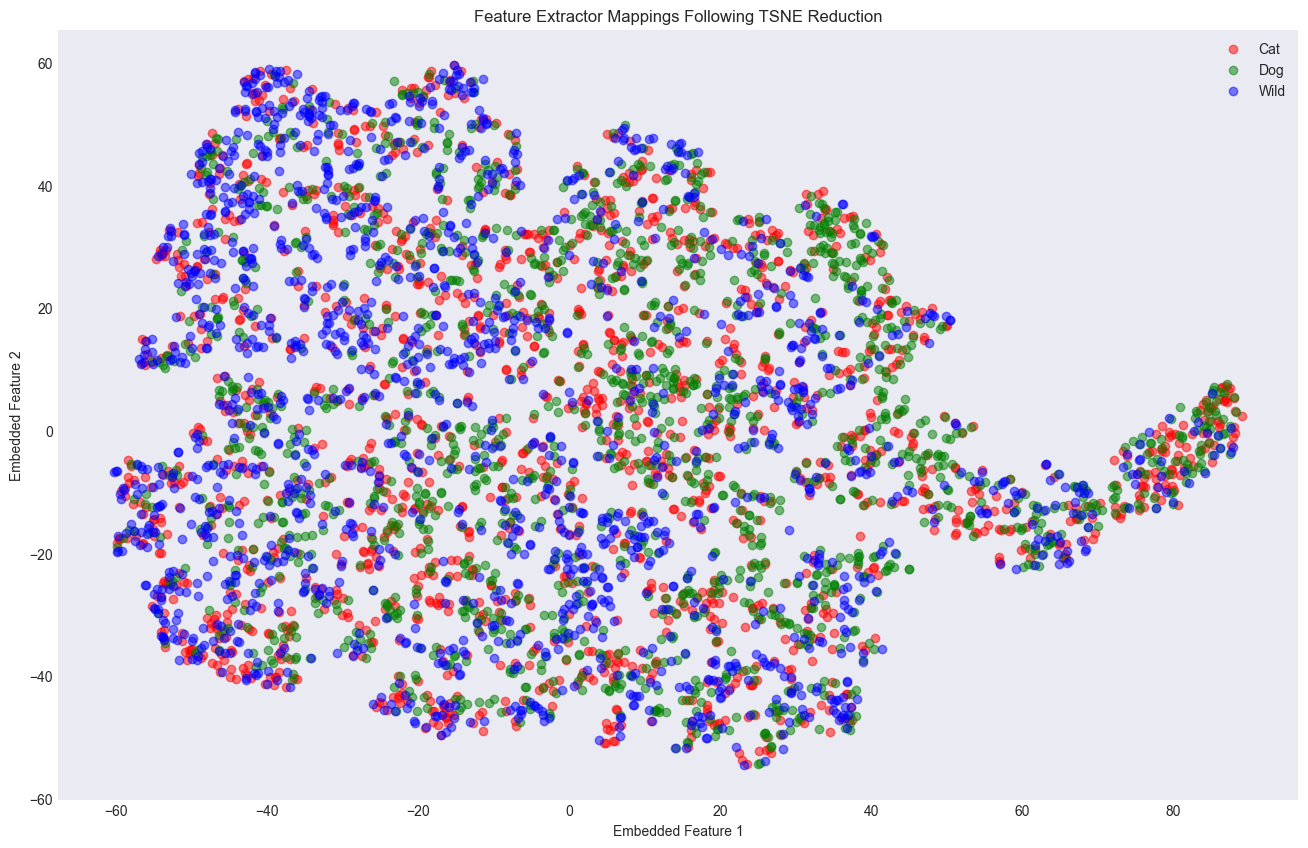

In [10]:
plot_tsne_embedding(embedding_dataframe)


- From the extractions following the application of TSNE on the Colorectal model feature extractor, it can be seen that the classes are messly seperated.
- This may be due to exactly what kind of data the model was trained on. Since the features and their distributions between the Colorectal Cancer set and the Animal Faces set are very different, the features are not as transferable.

- Pass the features to the training loop of the classifier

In [11]:
numpy_full_train_feature_map_set = full_train_feature_map_set.cpu().numpy()

numpy_full_train_label_set = full_train_label_set.cpu().numpy()
logistic_regression_classifier.fit(numpy_full_train_feature_map_set, numpy_full_train_label_set)

numpy_full_test_feature_map_set = full_test_feature_map_set.cpu().numpy()
regression_predictions = logistic_regression_classifier.predict(numpy_full_test_feature_map_set)

numpy_full_test_label_set = full_test_label_set.cpu().numpy()
print(f"Logistic Regression test accuracy: {logistic_regression_classifier.score(numpy_full_test_feature_map_set, numpy_full_test_label_set):.2f}%")


Logistic Regression test accuracy: 0.50%


c:\Users\trist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- Plot the results

In [12]:
print(sklearn.metrics.classification_report(numpy_full_test_label_set, regression_predictions, target_names=label_names))


              precision    recall  f1-score   support

         Cat       0.47      0.33      0.39       420
         Dog       0.45      0.54      0.49       367
        Wild       0.58      0.65      0.61       413

    accuracy                           0.50      1200
   macro avg       0.50      0.50      0.49      1200
weighted avg       0.50      0.50      0.49      1200



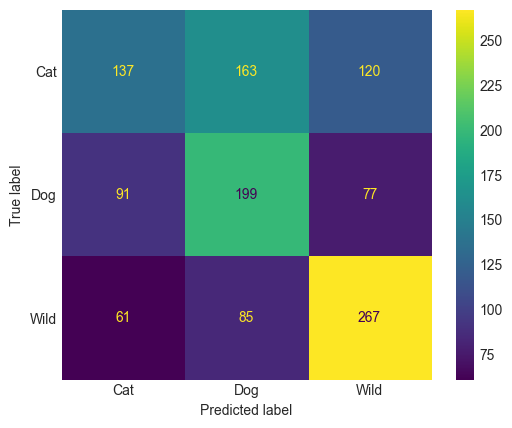

In [13]:
matrix = sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(numpy_full_test_label_set, regression_predictions), display_labels=label_names)
matrix.plot()

plt.show()


- Discussion

- From the information shown in the classification report and the confusion matrix, the following observations can be made
    - Overall, it seems that the Colorectal Cancer ResNet model has a very hard time at extracting quality features to help the Logistic Regression model correctly classify the data
    - The classifier produced 597 False Negative (Type I) errors and 597 False Positive (Type II) errors and the majority of those errors came from the "Cat" class
    - The classifier tends to be very consistent thanks to the feature extractor in light of the balance of Type I & II errors

#### ImageNet Pre-trained Model

- Get the model from pytorch with a ImageNet preset

In [2]:
imagenet_model = resnet50(weights=ResNet50_Weights.DEFAULT)


- Remove the classification head

In [3]:
# uncomment to see list of layers except fc
# train_nodes, eval_nodes = get_graph_node_names(imagenet_model)
# print(train_nodes[:-1])

return_nodes = {
    'layer1': 'layer1',
    'layer2': 'layer2',
    'layer3': 'layer3',
    'layer4': 'layer4',
    'avgpool': 'avgpool'
}

# Note: this created model does not contain the flatten layer and so the output needs to have that applied first before going to the classifier
imagenet_model = create_feature_extractor(imagenet_model, return_nodes=return_nodes)


- Load the dataset and preprocess it

In [70]:
train_dataloader, test_dataloader = create_dataloaders()


- Get the Logistic Regression model

In [72]:
logistic_regression_classifier


LogisticRegression(random_state=42)

- Extract the features

In [6]:
full_train_feature_map_set, full_test_feature_map_set, full_train_label_set, full_test_label_set = get_feature_and_label_maps(imagenet_model, train_dataloader, test_dataloader)


In [33]:
embedding_dataframe = create_embedding_dataframe(full_train_feature_map_set, full_train_label_set)


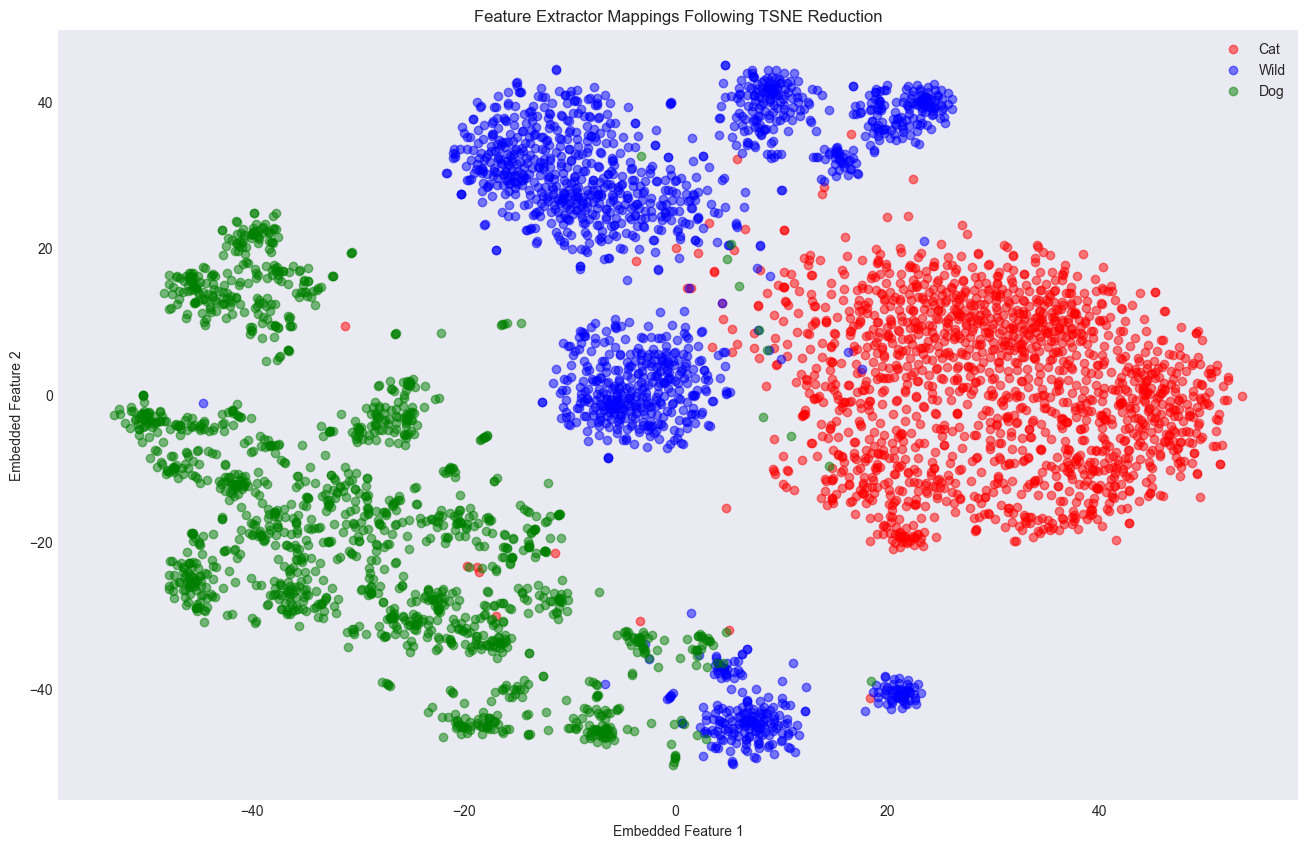

In [67]:
plot_tsne_embedding(embedding_dataframe)


- From the extractions following the application of TSNE on the ImageNet model feature extractor, it can be seen that there are clear separations between the classes.
- It should be noted however that some data points are mixed in between groups as the "Wild: class in particular has a mix of animals that may or may not be similar to cats and dogs in terms of noticable features

- Pass the features to the training loop for the classifier 

In [7]:
numpy_full_train_feature_map_set = full_train_feature_map_set.cpu().numpy()

numpy_full_train_label_set = full_train_label_set.cpu().numpy()
logistic_regression_classifier.fit(numpy_full_train_feature_map_set, numpy_full_train_label_set)

numpy_full_test_feature_map_set = full_test_feature_map_set.cpu().numpy()
regression_predictions = logistic_regression_classifier.predict(numpy_full_test_feature_map_set)

numpy_full_test_label_set = full_test_label_set.cpu().numpy()
print(f"Logistic Regression test accuracy: {logistic_regression_classifier.score(numpy_full_test_feature_map_set, numpy_full_test_label_set):.2f}%")


Logistic Regression test accuracy: 0.99%


- Plot the results

In [13]:
print(sklearn.metrics.classification_report(numpy_full_test_label_set, regression_predictions, target_names=label_names))


              precision    recall  f1-score   support

         Cat       1.00      0.99      1.00       384
         Dog       1.00      0.99      0.99       427
        Wild       0.99      1.00      0.99       389

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



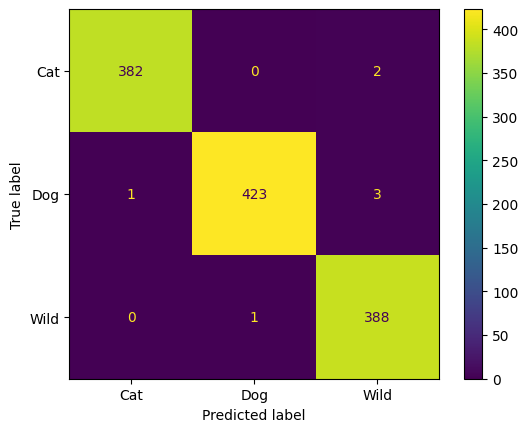

In [27]:
matrix = sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(numpy_full_test_label_set, regression_predictions), display_labels=label_names)
matrix.plot()

plt.show()


- Discussion

- From the information shown in the classification report and the confusion matrix, the following observations can be made
    - Overall, it seems that the ImageNet ResNet model is very good at extracting quality features to help the Logistic Regression model correctly classify the data
    - The classifier produced 7 False Negative (Type I) errors and 7 False Positive (Type II) errors and the majority of those errors came from the "Wild" class
    - The classifier tends to be very consistent thanks to the feature extractor in light of the balance of Type I & II errors